Only engagement data from period 0 and period 1 is available, so can only do churn modeling on that.
Majority don't have a cancel date, so they only unengaged.

In [101]:
# read in libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.metrics import auc, classification_report, f1_score, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [2]:
# read in data
subscribers = pd.read_pickle('data/subscribers')
customer_service_reps = pd.read_pickle('data/customer_service_reps')
engagement = pd.read_pickle('data/engagement')

spend = pd.read_csv('data/advertisingspend.csv')
spend['month'] = pd.to_datetime(spend['date'], infer_datetime_format=True).dt.to_period('M')
spend = spend.drop('date', axis = 1)

In [ ]:
# determine users to analyze
# we want people who passed their trial

### Prepare customers to analyze

In [3]:
# find customers from subscribers past trial
# definition: finished trial, made revenue > 0, didn't request refund
# keep any na's for revenue_net
subids_subs = subscribers[(subscribers['cancel_before_trial_end'] == True) & ~(subscribers['revenue_net'] < 1) & (subscribers['refund_after_trial_TF'] == False)].subid.values

len(subids_subs)

81788

In [4]:
# i want to get a record of for each payment period - did they churn, renew or need to predict

# filter to OTT and past trial
subids_csr = customer_service_reps[(customer_service_reps['billing_channel'] == 'OTT')]

# filter to people who fit my definition of subscribing
# finished trial, made revenue > 0
subids_csr = subids_csr[(subids_csr['trial_completed_TF'] == True) & (subids_csr['revenue_net_1month'] >0)]

# only interested in periods past trial
subids_csr = subids_csr[subids_csr['payment_period'] > 0]
subids_csr = subids_csr[['subid','account_creation_date','current_sub_TF', 'payment_period', 'renew', 'last_payment', 'next_payment', 'cancel_date']]

# max period
subids_csr['max_period'] = subids_csr.groupby('subid').payment_period.transform('max')

# filter to period 1
subids_csr = subids_csr[subids_csr['payment_period'] == 1]

subids_csr['churn_flag'] = np.where((subids_csr['payment_period'] == subids_csr['max_period']) & (subids_csr['current_sub_TF']==True), 'current',
                                   np.where(subids_csr['payment_period'] != subids_csr['max_period'], '0', '1'))

subids_csr['last_payment'] = subids_csr['last_payment'].dt.date

subids_csr.head()

,subid,account_creation_date,current_sub_TF,payment_period,renew,last_payment,next_payment,cancel_date,max_period,churn_flag
63,27800927,2020-03-27 23:59:04,True,1,False,2020-04-11,NaT,NaT,1,current
69,28893238,2020-03-27 23:58:43,True,1,NaN,2020-04-11,NaT,NaT,1,current
73,20277508,2020-03-27 23:58:18,True,1,NaN,2020-04-11,NaT,NaT,1,current
75,22127034,2020-03-27 23:58:08,True,1,NaN,2020-04-11,NaT,NaT,1,current
77,27089117,2020-03-27 23:57:48,True,1,False,2020-04-19,NaT,NaT,1,current


In [5]:
subids = subids_csr[subids_csr['subid'].isin(subids_subs)][['subid', 'churn_flag', 'last_payment', 'cancel_date']]

subids.head()

,subid,churn_flag,last_payment,cancel_date
125,23796492,current,2020-04-11,NaT
135,20162910,current,2020-04-11,NaT
173,22120282,current,2020-04-11,NaT
211,22652005,current,2020-04-11,NaT
266,25839343,current,2020-04-11,NaT


In [11]:
churnsubs_count = subids.churn_flag.value_counts()

churnsubs_count

current    20498
1          16942
0          14929
Name: churn_flag, dtype: int64

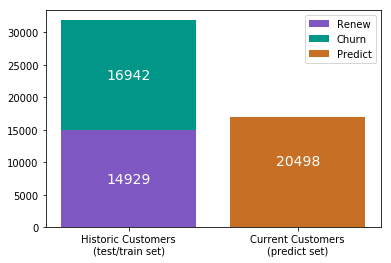

In [30]:
xlabel = ['Historic Customers\n(test/train set)', 'Current Customers\n(predict set)']

plt.bar(xlabel[0], churnsubs_count['0'], label = 'Renew', color = '#7e57c2')
plt.bar(xlabel[0], churnsubs_count['1'], bottom = churnsubs_count['0'], label = 'Churn', color = '#009688')
plt.bar(xlabel[1], churnsubs_count['1'], label = 'Predict', color = '#c77025')

plt.text(xlabel[0], churnsubs_count['0']/2, churnsubs_count['0'], ha='center', va='center', color = 'white', size = 14)
plt.text(xlabel[0], churnsubs_count['0'] + churnsubs_count['1']/2, churnsubs_count['1'], 
         ha='center', va='center', color = 'white', size = 14)
plt.text(xlabel[1], churnsubs_count['current']/2, churnsubs_count['current'], 
         ha='center', va='center', color = 'white', size = 14)

plt.legend()
plt.show()

In [142]:
len(subids)

52369

### Engagement data - descriptive analysis

In [444]:
csr_churn = customer_service_reps.copy()

# adjust payment period for non-ott
csr_churn['payment_period'] = np.where(csr_churn['billing_channel'] == 'OTT', csr_churn['payment_period'],
                                      ((customer_service_reps['payment_period'] - 1) // 4) + 1)

csr_churn['max_period'] = csr_churn.groupby('subid').payment_period.transform('max')

# filter to customers who had revenue > 0 and revenue > 0
csr_churn = csr_churn[(csr_churn['max_period'] > 0) & (csr_churn['revenue_net_1month'] > 0)]

csr_churn = csr_churn[csr_churn['payment_period'] == 1]

#filter out current subs in period 1
csr_churn = csr_churn[~((csr_churn['current_sub_TF'] == True) & (csr_churn['max_period'] == 1))]

# make churn flag
csr_churn['churn_flag'] = np.where(csr_churn['max_period'] == 1, 1, 0)

csr_churn = csr_churn[['subid', 'billing_channel', 'churn_flag']]

csr_churn.head()

,subid,billing_channel,churn_flag
5,25108574,itunes,1
6,25108574,itunes,1
7,25108574,itunes,1
1589,28930628,OTT,1
7858,28348181,OTT,1


In [445]:
csr_churn.groupby('billing_channel').churn_flag.mean()

billing_channel
OTT       0.527977
google    0.717378
itunes    0.708305
Name: churn_flag, dtype: float64

In [439]:
subids[subids['churn_flag'] != 'current'].churn_flag.astype(int).mean()

0.5315804336230429

In [433]:
csr_churn['churn_flag'].mean()

0.49507508324136995

In [430]:
len(csr_churn)

316249

In [395]:
engage_sub = engagement.merge(subids,on ='subid')

engage_sub['isnull'] = np.where(engage_sub['app_opens'].isna(), True, False)

engage_sub.groupby(['payment_period', 'isnull']).subid.count()

payment_period  isnull
0.0             False      654423
1.0             False     1089568
2.0             False      260217
3.0             False          85
                True        34559
Name: subid, dtype: int64

Only Engagement period 3 has nulls so it should be excluded for fairness.

### Engagement Data - create model features

In [396]:
# count of dates
df_engage = engagement[(engagement['payment_period'] > 0) & (engagement['payment_period'] < 3)].drop('payment_period', axis = 1)

df_engage = df_engage.groupby('subid').agg({'date': ['min', 'max'], 'app_opens': ['count', 'sum'],
                                           'cust_service_mssgs' : 'sum', 'num_videos_rated': 'sum',
                                           'num_videos_completed': 'sum', 'num_videos_more_than_30_seconds': 'sum',
                                           'num_series_started': 'sum'}).reset_index()
df_engage.columns = ['subid','date_min', 'date_max', 'active_days', 
                     'app_opens', 'cust_service_mssgs', 'num_videos_rated', 'num_videos_completed',
                    'num_videos_more_than_30_seconds', 'num_series_started']

df_engage['total_days'] = (df_engage['date_max'] - df_engage['date_min']).dt.days + 1

#creating the features i want
df_engage['active_pct'] = df_engage['active_days'] / df_engage['total_days']
df_engage['avg_app_opens'] = df_engage['app_opens'] / df_engage['total_days']
df_engage['avg_cust_service'] = df_engage['cust_service_mssgs'] / df_engage['total_days']
df_engage['avg_videos_completed'] = df_engage['num_videos_completed'] / df_engage['total_days']
df_engage['avg_videos_viewed'] = df_engage['num_videos_more_than_30_seconds'] / df_engage['total_days']
df_engage['avg_videos_rated'] = df_engage['num_videos_rated'] / df_engage['total_days']
df_engage['avg_series_started'] = df_engage['num_series_started'] / df_engage['total_days']
df_engage['pct_video_completed'] = df_engage['num_videos_completed'] / df_engage['num_videos_more_than_30_seconds']
df_engage['pct_video_rated'] = df_engage['num_videos_rated'] / df_engage['num_videos_more_than_30_seconds']
df_engage['pct_series_started'] = df_engage['num_series_started'] / df_engage['num_videos_more_than_30_seconds']
df_engage['vids_per_session'] = df_engage['num_videos_more_than_30_seconds'] / df_engage['app_opens']

# fill inf and nan
df_engage = df_engage.fillna(0)
df_engage['pct_video_rated'] = np.where(np.isinf(df_engage['pct_video_rated']), 1, df_engage['pct_video_rated'])
df_engage['pct_series_started'] = np.where(np.isinf(df_engage['pct_series_started']), 1, df_engage['pct_series_started'])
df_engage['vids_per_session'] = np.where(np.isinf(df_engage['vids_per_session']), df_engage['num_videos_more_than_30_seconds'], df_engage['vids_per_session'])

# drop what I don't want
df_engage = df_engage.drop(engagement.columns.values[2:-1], axis = 1)
df_engage = df_engage.drop(['date_min', 'date_max', 'active_days', 'total_days'], axis = 1)

df_engage.describe()

,subid,active_pct,avg_app_opens,avg_cust_service,avg_videos_completed,avg_videos_viewed,avg_videos_rated,avg_series_started,pct_video_completed,pct_video_rated,pct_series_started,vids_per_session
count,5.389800e+04,53898.000000,53898.000000,53898.000000,53898.000000,53898.000000,53898.000000,53898.000000,53898.000000,53898.000000,53898.000000,53898.000000
mean,2.499236e+07,0.836170,1.739503,0.286627,1.660783,3.372120,0.071055,0.497344,0.420237,0.017607,0.132477,3.098082
std,2.891547e+06,0.241400,1.736451,0.518787,1.618060,1.310131,0.159416,0.392475,0.376540,0.038381,0.110046,2.431507
min,2.000060e+07,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.248199e+07,0.733333,0.741935,0.054545,0.032258,2.551724,0.000000,0.041667,0.015152,0.000000,0.026316,1.571429
50%,2.498479e+07,0.983607,1.000000,0.180328,1.129032,3.967742,0.000000,0.517241,0.345238,0.000000,0.154762,2.603913
75%,2.750633e+07,1.000000,2.225806,0.344262,3.322581,4.258065,0.064516,0.903226,0.801587,0.017544,0.218487,4.275862
max,2.999994e+07,1.000000,40.032258,23.000000,8.000000,12.000000,4.032258,1.032787,1.000000,1.000000,6.250000,132.000000


In [397]:
# compare means to get a sense of whether it is correlated

df_engage.merge(subids, on ='subid').drop('subid', axis = 1).groupby('churn_flag').mean()

,active_pct,avg_app_opens,avg_cust_service,avg_videos_completed,avg_videos_viewed,avg_videos_rated,avg_series_started,pct_video_completed,pct_video_rated,pct_series_started,vids_per_session
churn_flag,,,,,,,,,,,
0,0.818216,1.747826,0.187562,1.770638,3.186160,0.075108,0.541669,0.465713,0.019262,0.150746,2.893043
1,0.835450,1.678639,0.263734,1.682629,3.354223,0.073420,0.493113,0.421965,0.018110,0.129937,3.213418
current,0.840212,1.863610,0.230516,1.807385,3.441073,0.074478,0.541064,0.448925,0.018145,0.140384,3.027852


### Combine for model

In [402]:
# combine model features
df_model = subids[['subid', 'churn_flag']].merge(df_engage,on ='subid')

#drop some highly correlated variables
df_model = df_model.drop(['avg_videos_completed', 'avg_videos_rated'], axis = 1) 

# customers to predict on
X_predict = df_model[df_model['churn_flag'] == 'current'].drop(['subid', 'churn_flag'], axis = 1)

# split to test train
X = df_model[df_model['churn_flag'] != 'current'].drop(['subid', 'churn_flag'],axis=1)
y = df_model[df_model['churn_flag'] != 'current']['churn_flag'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=10)

# scale
scaler = StandardScaler()

X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)
X_predict_scale = scaler.transform(X_predict)

X_predict.head()

,active_pct,avg_app_opens,avg_cust_service,avg_videos_viewed,avg_series_started,pct_video_completed,pct_video_rated,pct_series_started,vids_per_session
0,1.000000,6.266667,0.4,4.466667,0.733333,0.970149,0.000000,0.164179,0.712766
1,0.307692,0.307692,0.0,0.769231,0.000000,0.000000,0.000000,0.000000,2.500000
2,0.428571,0.428571,0.0,0.714286,0.000000,0.000000,0.000000,0.000000,1.666667
3,0.933333,1.733333,0.2,3.600000,0.666667,0.703704,0.055556,0.185185,2.076923
4,1.000000,4.666667,0.0,4.466667,1.000000,0.731343,0.000000,0.223881,0.957143


In [403]:
# check for correlation between predictor variables
X.corr()

,active_pct,avg_app_opens,avg_cust_service,avg_videos_viewed,avg_series_started,pct_video_completed,pct_video_rated,pct_series_started,vids_per_session
active_pct,1.000000,0.454525,0.331661,0.846381,0.650947,0.537467,0.244207,0.413032,-0.209318
avg_app_opens,0.454525,1.000000,0.173201,0.451434,0.497290,0.453556,0.082893,0.323890,-0.447695
avg_cust_service,0.331661,0.173201,1.000000,0.383451,0.209614,0.241739,0.223793,0.103739,-0.018057
avg_videos_viewed,0.846381,0.451434,0.383451,1.000000,0.696557,0.582046,0.261979,0.409181,-0.065340
avg_series_started,0.650947,0.497290,0.209614,0.696557,1.000000,0.794948,0.365294,0.755336,-0.206310
pct_video_completed,0.537467,0.453556,0.241739,0.582046,0.794948,1.000000,0.417858,0.572670,-0.177285
pct_video_rated,0.244207,0.082893,0.223793,0.261979,0.365294,0.417858,1.000000,0.262959,0.012183
pct_series_started,0.413032,0.323890,0.103739,0.409181,0.755336,0.572670,0.262959,1.000000,-0.166858
vids_per_session,-0.209318,-0.447695,-0.018057,-0.065340,-0.206310,-0.177285,0.012183,-0.166858,1.000000


#### Linear Regression

In [404]:
# linear regression

import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X_train_scale)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             churn_flag   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     89.52
Date:                Fri, 15 May 2020   Prob (F-statistic):          6.16e-164
Time:                        21:52:30   Log-Likelihood:                -12786.
No. Observations:               18248   AIC:                         2.559e+04
Df Residuals:                   18238   BIC:                         2.567e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5416      0.004    150.015      0.0

In [405]:
# LASSO

# tuning hyperparameters
clf = Lasso()

# Tune the hyperparameter
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 100]}

# Grid Search
grid_search = GridSearchCV(clf, param_grid, cv=5, return_train_score=True, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_scale, y_train)

print('Grid Search Params')
print(grid_search.best_params_)

# don't do cross validation for linear
clf = grid_search.best_estimator_
clf.fit(X_train_scale, y_train)

y_pred_prob = clf.predict(X_test_scale)
#y_pred_prob = [1 if i > 1 else i for i in y_pred_prob] 

y_pred_train = clf.predict(X_train_scale).round()
#y_pred_train = [1 if i > 1 else i for i in y_pred_prob] 

y_pred = y_pred_prob.round()

print('Training accuracy: %.2f%%' % (accuracy_score(y_train, y_pred_train) * 100))
print('Test accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
print('AUC: %.2f%%' % (metrics.roc_auc_score(y_test,y_pred_prob) * 100))

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

fpr_linear, tpr_linear, _ = roc_curve(y_test, y_pred_prob)

Grid Search Params
{'alpha': 0.01}
Training accuracy: 58.81%
Test accuracy: 58.75%
AUC: 62.72%
[[1855 3773    0    0]
 [1241 5292    4    1]
 [   0    0    0    0]
 [   0    0    0    0]]
              precision    recall  f1-score   support

         0.0       0.60      0.33      0.43      5628
         1.0       0.58      0.81      0.68      6538
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0

    accuracy                           0.59     12166
   macro avg       0.30      0.28      0.28     12166
weighted avg       0.59      0.59      0.56     12166



/Users/Sandra/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/Sandra/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/Sandra/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [406]:
# RIDGE

# tuning hyperparameters
clf = Ridge()

# Tune the hyperparameter
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 100]}

# Grid Search
grid_search = GridSearchCV(clf, param_grid, cv=5, return_train_score=True, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_scale, y_train)

print('Grid Search Params')
print(grid_search.best_params_)

# don't do cross validation for linear
clf = grid_search.best_estimator_
clf.fit(X_train_scale, y_train)

y_pred_prob = clf.predict(X_test_scale)
#y_pred_prob = [1 if i > 1 else i for i in y_pred_prob] 

y_pred_train = clf.predict(X_train_scale).round()
#y_pred_train = [1 if i > 1 else i for i in y_pred_prob] 

y_pred = y_pred_prob.round()

print('Training accuracy: %.2f%%' % (accuracy_score(y_train, y_pred_train) * 100))
print('Test accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
print('AUC: %.2f%%' % (metrics.roc_auc_score(y_test,y_pred_prob) * 100))

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))



Grid Search Params
{'alpha': 100}
Training accuracy: 58.96%
Test accuracy: 59.54%
AUC: 62.60%
[[2457 3171    0    0]
 [1744 4787    5    2]
 [   0    0    0    0]
 [   0    0    0    0]]
              precision    recall  f1-score   support

         0.0       0.58      0.44      0.50      5628
         1.0       0.60      0.73      0.66      6538
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0

    accuracy                           0.60     12166
   macro avg       0.30      0.29      0.29     12166
weighted avg       0.59      0.60      0.59     12166



/Users/Sandra/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/Sandra/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/Sandra/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### Logistic Regression

In [407]:
# tuning hyperparameters
clf = LogisticRegression(random_state=1)

# Tune the hyperparameter
param_grid = {'penalty': ['l1', 'l2'],
             'C': [0.001, 0.01, 0.1, 1, 100]}

# Grid Search
grid_search = GridSearchCV(clf, param_grid, cv=5, return_train_score=True, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_scale, y_train)

print('Grid Search Params')
print(grid_search.best_params_)

# apply to model to get scores
clf_gridsearch = grid_search.best_estimator_

scores = cross_validate(clf_gridsearch, X_train_scale, y_train, cv=5, scoring = ['accuracy', 'roc_auc'], return_train_score=True)

print('Cross Validation Results')
print('Train accuracy CV: %.4f' % scores['train_accuracy'].mean())
print('Test accuracy CV: %.4f' % scores['test_accuracy'].mean())
print('Test AUC: %.4f' % scores['test_roc_auc'].mean())

/Users/Sandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Sandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Sandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Grid Search Params
{'C': 0.1, 'penalty': 'l1'}


/Users/Sandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Sandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Sandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Cross Validation Results
Train accuracy CV: 0.5966
Test accuracy CV: 0.5954
Test AUC: 0.6264


In [408]:
clf = grid_search.best_estimator_
clf.fit(X_train_scale, y_train)
y_pred_prob = clf.predict_proba(X_test_scale)[:,1]
y_pred = clf.predict(X_test_scale)

print('Training accuracy: %.2f%%' % (clf.score(X_train_scale, y_train) * 100))
print('Test accuracy: %.2f%%' % (clf.score(X_test_scale, y_test) * 100))
print('AUC: %.2f%%' % (metrics.roc_auc_score(y_test,y_pred_prob) * 100))

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_prob)

Training accuracy: 59.66%
Test accuracy: 59.81%
AUC: 63.09%
[[2689 2939]
 [1951 4587]]
              precision    recall  f1-score   support

           0       0.58      0.48      0.52      5628
           1       0.61      0.70      0.65      6538

    accuracy                           0.60     12166
   macro avg       0.59      0.59      0.59     12166
weighted avg       0.60      0.60      0.59     12166



/Users/Sandra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [409]:
coefs = pd.DataFrame(clf_gridsearch.coef_[0], index = X_train.columns, columns=['coefs'])
coefs

,coefs
active_pct,-0.057466
avg_app_opens,-0.001901
avg_cust_service,0.415251
avg_videos_viewed,0.332246
avg_series_started,-0.130273
pct_video_completed,-0.151296
pct_video_rated,-0.033404
pct_series_started,-0.245327
vids_per_session,0.068428


#### Decision Tree

In [410]:
# tuning hyperparameters
clf = DecisionTreeClassifier(criterion = 'entropy')

# Tune the hyperparameter
param_grid = {'max_depth': [3, 5, 10, 20],
             'min_samples_leaf': [3, 10, 50],
             'max_features': [3, 5, 7]}

# Grid Search
grid_search = GridSearchCV(clf, param_grid, cv=5, return_train_score=True, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Grid Search Params')
print(grid_search.best_params_)

# apply to model to get scores
clf_gridsearch = grid_search.best_estimator_

scores = cross_validate(clf_gridsearch, X_train, y_train, cv=5, scoring = ['accuracy', 'roc_auc'], return_train_score=True)

print('Cross Validation Results')
print('Train accuracy CV: %.4f' % scores['train_accuracy'].mean())
print('Test accuracy CV: %.4f' % scores['test_accuracy'].mean())
print('Test AUC: %.4f' % scores['test_roc_auc'].mean())

Grid Search Params
{'max_depth': 20, 'max_features': 7, 'min_samples_leaf': 50}
Cross Validation Results
Train accuracy CV: 0.8053
Test accuracy CV: 0.7724
Test AUC: 0.8757


In [411]:
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 20, max_features = 7, min_samples_leaf = 50)
clf.fit(X_train, y_train)

# apply model to test set
y_pred_prob = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)

print('Training accuracy: %.2f%%' % (clf.score(X_train, y_train) * 100))
print('Test accuracy: %.2f%%' % (clf.score(X_test, y_test) * 100))
print('AUC: %.2f%%' % (metrics.roc_auc_score(y_test,y_pred_prob) * 100))

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

# creat roc curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_prob)

Training accuracy: 80.67%
Test accuracy: 78.34%
AUC: 88.55%
[[4258 1370]
 [1265 5273]]
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      5628
           1       0.79      0.81      0.80      6538

    accuracy                           0.78     12166
   macro avg       0.78      0.78      0.78     12166
weighted avg       0.78      0.78      0.78     12166



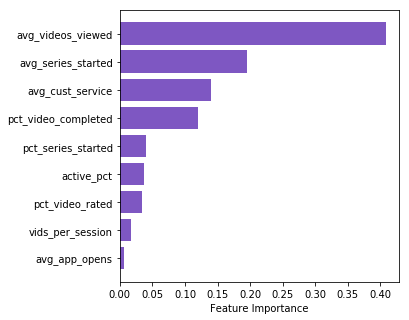

In [412]:
feature_importances = pd.DataFrame(clf.feature_importances_, index = X.columns, columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize = [5,5])
plt.barh(feature_importances.index, feature_importances['importance'], color = '#7e57c2')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.show()

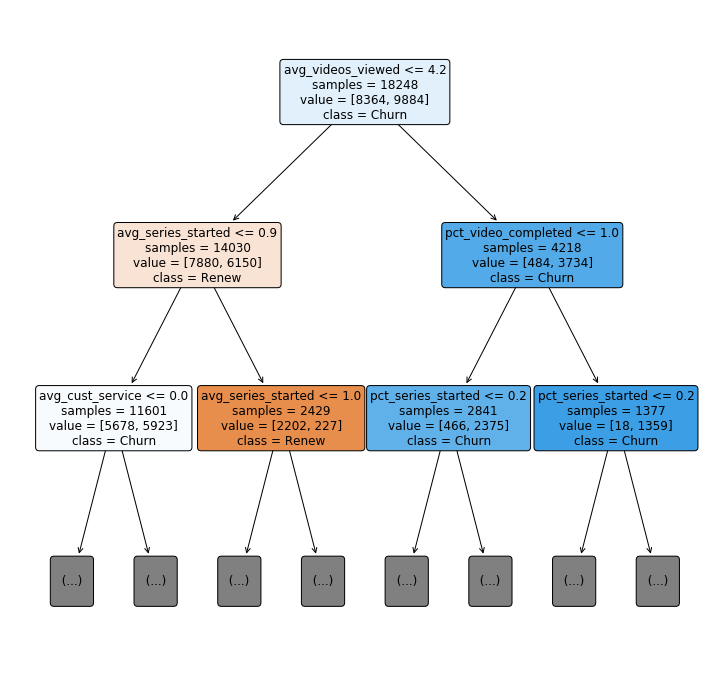

In [413]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12,12))
plot_tree(clf, feature_names=X.columns, class_names=['Renew', 'Churn'] 
   , filled = True, impurity = False, precision = 1, rounded = True, max_depth = 2, fontsize = 12)
plt.show()

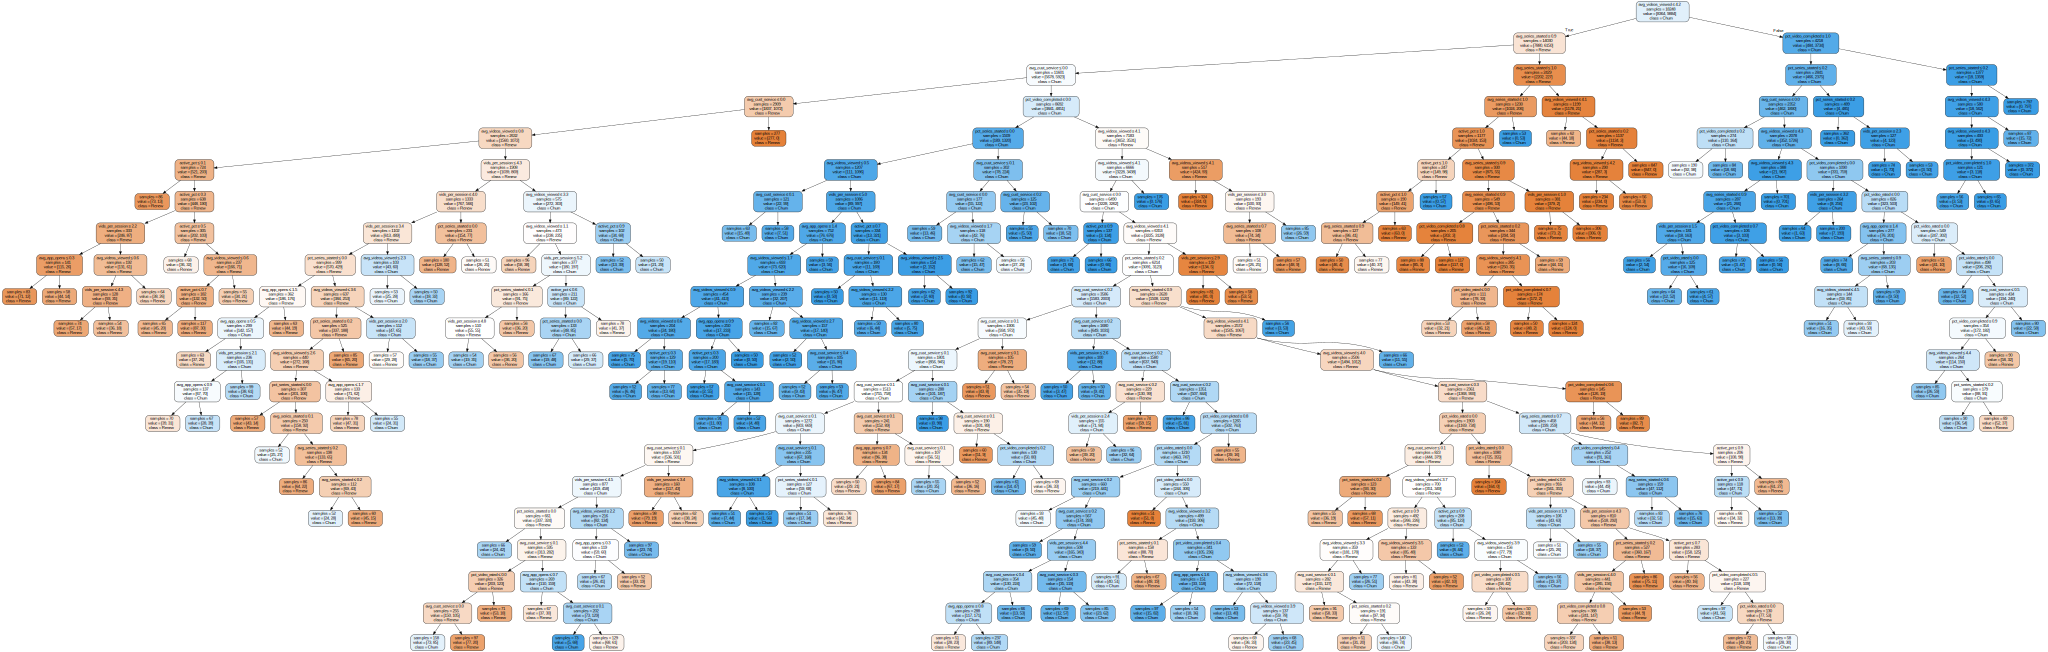

'churn_tree.pdf'

In [414]:
from IPython.display import SVG, display, Image
from graphviz import Source

graph = Source(export_graphviz(clf, out_file=None
   , feature_names=X.columns, class_names=['Renew', 'Churn'] 
   , filled = True, impurity = False, precision = 1, special_characters=True, rounded = True))
display(SVG(graph.pipe(format='svg')))

graph.render(filename='churn_tree')

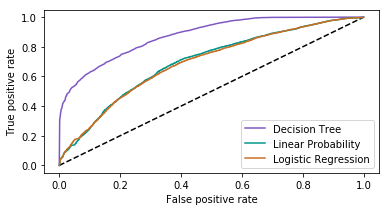

In [98]:
plt.figure(figsize = (6,3))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dt, tpr_dt, label = 'Decision Tree', color = '#7e57c2')
plt.plot(fpr_linear, tpr_linear, label = 'Linear Probability', color = '#009688')
plt.plot(fpr_log, tpr_log, label = 'Logistic Regression', color = '#c77025')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

#### Make Predictions on current customers

In [294]:
# apply model to predict set (current customers)
y_current_prob = clf.predict_proba(X_predict)[:,1]

pd.DataFrame(y_current_prob).describe()

,0
count,19222.000000
mean,0.711278
std,0.273163
min,0.000000
25%,0.506757
50%,0.752067
75%,1.000000
max,1.000000


In [297]:
# put into table and save it
current_churnpred = pd.concat([df_model[df_model['churn_flag'] == 'current'][['subid']].reset_index(drop = True), 
           pd.DataFrame({'churn_prob': y_current_prob})], axis = 1)

current_churnpred.to_pickle('current_churnpred')
current_churnpred.head()

,subid,churn_prob
0,23796492,0.840580
1,20162910,0.500000
2,22120282,0.271186
3,22652005,0.417027
4,25839343,0.696629


### Revenue Modeling

In [257]:
discount = 0.1
acceptance = 0.2
price = 4.5

list_prices = [price, price*(1-discount), price*(1-discount), 0]

In [191]:
simulations = 10

# for a specified number of simulatiosn and given threshold, calculate average number of people taking full price, offer, churn
def rev_simulation(threshold, simulations):
    c_fullprice = 0
    c_offer_renew = 0
    c_offer_churn = 0
    c_churn = 0
    
    for s in range(0,simulations):

        for i in range(0, len(y_pred_prob)):
            #determine if you want to give them the offer
            if y_pred_prob[i] > threshold:
                give_offer = 1
            else:
                give_offer = 0

            # determine if they will take up the offer
            if np.random.random() < acceptance:
                accept_offer = 1
            else:
                accept_offer = 0

            # determine what they do
            if give_offer * accept_offer > 0: # they take offer
                if y_test.values[i] == 0: #offer but they renew
                    c_offer_renew += 1
                else:
                    c_offer_churn += 1
            elif y_test.values[i] == 0: # they take full price
                c_fullprice += 1
            else: # they churn
                c_churn += 1
        
    return [c_fullprice/simulations, c_offer_renew/simulations, c_offer_churn/simulations, c_churn/simulations]

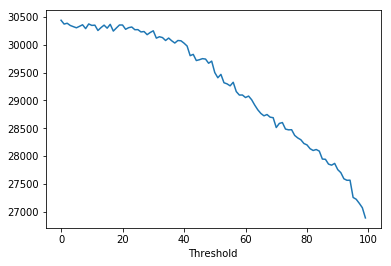

In [258]:
# test which threshold leads to most revenue
# use simulation of 10 for ease of analysis

list_rev = []

for i in range(0,100):
    rev = np.multiply(rev_simulation(i/100,10), list_prices).sum()
    list_rev.append(rev)
    
plt.plot(range(0,100), list_rev)
plt.xlabel('Threshold %')
plt.show()

Revenue is highest when you offer it to everyone. This makes sense because the churn rate is so high.

In [263]:
# revenue for do nothing
rev_donothing = np.multiply(rev_simulation(1,1), list_prices).sum()
rev_donothing

25461.0

In [1]:
def print_revresults(sim): #input the results of the simulation
    revperprice = np.multiply(sim, list_prices)
    totalrev = revperprice.sum()
    revdiff = (totalrev - rev_donothing)/rev_donothing

    print('Take Up:')
    print(sim)
    print('Revenue Per Price:')
    print(revperprice)
    print('Total revenue:')
    print(totalrev)
    print('% change:')
    print(revdiff)

In [266]:
# do nothing case
s_100 = rev_simulation(1,1)

print_revresults(s_100)

Take Up:
[5658.0, 0.0, 0.0, 6518.0]
Revenue Per Price:
[25461.     0.     0.     0.]
Total revenue:
25461.0
% change:
0.0


In [267]:
# offer to everyone
s_0 = rev_simulation(0,10000)

print_revresults(s_0)

Take Up:
[4844.5675, 813.4325, 1301.4584, 5216.5416]
Revenue Per Price:
[21800.55375   3294.401625  5270.90652      0.      ]
Total revenue:
30365.861895
% change:
0.16152552863344302


In [268]:
# threshold 50%

#s_50 rev_simulation(0.5,10000)
print_revresults(s_50)

Take Up:
[5369.2395, 288.7605, 1048.2783, 5469.7217]
Revenue Per Price:
[24161.57775   1169.480025  4245.527115     0.      ]
Total revenue:
29576.58489
% change:
0.13915010489907845


In [269]:
# threshold 25%

#s_50 rev_simulation(0.25,10000)
print_revresults(s_25)

Take Up:
[5055.5, 602.5, 1258.2773, 5259.7227]
Revenue Per Price:
[22749.75      2440.125     5096.023065     0.      ]
Total revenue:
30285.898065
% change:
0.15931170522481256
